# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Combine the datasets

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

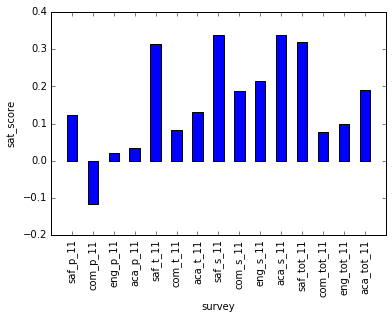

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

corr = correlations.dropna()
corr = corr["saf_p_11":"aca_tot_11"]
bar_left = numpy.arange(len(corr)) + 0.75
bar_xtick_pos = range(1, len(corr)+1)
bar_height = corr.values
bar_xticks = corr.index
fig, ax = plt.subplots()
ax.bar(left=bar_left, height=bar_height, width=0.5)
ax.set_xticks(bar_xtick_pos)
ax.set_xticklabels(bar_xticks, rotation=90)
ax.set_xlabel("survey")
ax.set_ylabel("sat_score")
plt.show()

# findings
The safety and respect scores have the largest correlations with sat scores among the four fields.
The scores based on student and teacher responses have larger correlations with sat score than those based on parents.
Score based on parents responses does not have a strong correlation with sat scores, in the case of communication score, they even have a negative correlation.

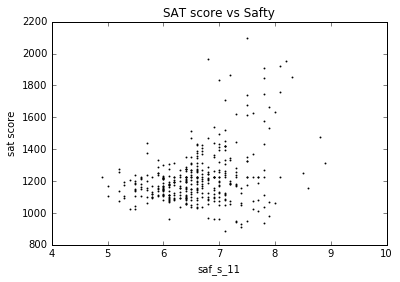

In [11]:
fig, ax = plt.subplots()
ax.scatter(combined["saf_s_11"], combined["sat_score"], s=0.8)
ax.set_xlabel("saf_s_11")
ax.set_ylabel("sat score")
ax.set_title("SAT score vs Safty")
plt.show()

The corralation seems to come from a small group of school with very high Safty score and SAT score.

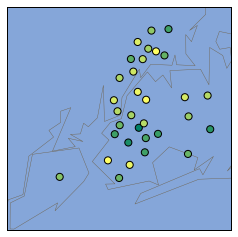

In [12]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

dist_group = combined.groupby("school_dist")
ave_dist = dist_group.agg(numpy.mean)
longitudes = ave_dist["lon"].tolist()
latitudes = ave_dist["lat"].tolist()
saf = ave_dist["saf_s_11"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=saf, cmap="summer")
plt.show()

The average safe scores are high in Manhattan. Lowest safty score appears mainly in Brooklyn.

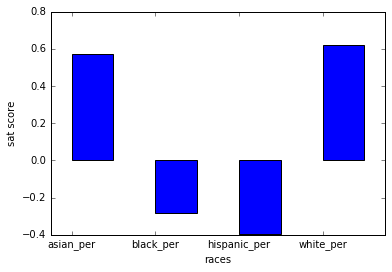

In [13]:
score_race = correlations[["asian_per", "black_per", "hispanic_per", "white_per"]]
sc_left = numpy.arange(4) + 0.75
sc_height = score_race.values.tolist()
sc_ticks = score_race.index.tolist()
fig, ax = plt.subplots()
ax.bar(sc_left, sc_height, width=0.5)
ax.set_xlabel("races")
ax.set_ylabel("sat score")
ax.set_xticks(sc_left)
ax.set_xticklabels(sc_ticks)
plt.show()

The percentages of asian and white students have high corrations with average sat scores, while the percentaes of black and hispanic students have a negative one.

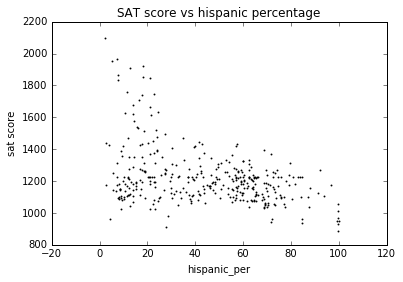

In [14]:
fig, ax = plt.subplots()
ax.scatter(combined["hispanic_per"], combined["sat_score"], s=0.8)
ax.set_xlabel("hispanic_per")
ax.set_ylabel("sat score")
ax.set_title("SAT score vs hispanic percentage")
plt.show()

The scatter plots shows an interesting thing. Despite the negative corration value we have just found, most school with a large range of hispanic student percentage has a sat score close to median. There are two group of schools leading to the negative corration: a group of school with very low hispanic student percentage and very high sat score, and a small group of school with almost 100% hispanic students and very low sat score.

In [15]:
high_hisp = combined[combined["hispanic_per"] > 95]
print(high_hisp["school_name"])         

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


The are all international schools, with high English learners and low sat score.

In [16]:
high_sat = combined[combined["hispanic_per"] < 10]
high_sat = high_sat[high_sat["sat_score"] > 1800]
print(high_sat["school_name"]) 

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


They are all famous schools. Most of their students come from high class.

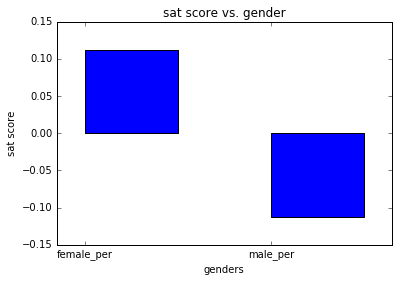

In [17]:
score_sex = correlations[["female_per", "male_per"]]
sx_left = numpy.arange(2) + 0.75
sx_height = score_sex.values.tolist()
sx_ticks = score_sex.index.tolist()
fig, ax = plt.subplots()
ax.bar(sx_left, sx_height, width=0.5)
ax.set_xlabel("genders")
ax.set_ylabel("sat score")
ax.set_xticks(sx_left)
ax.set_xticklabels(sx_ticks)
ax.set_title("sat score vs. gender")
plt.show()

Sat score has a positive correlation with female student percentage, and a negative male student percentage. But both correlations have small absolute values.

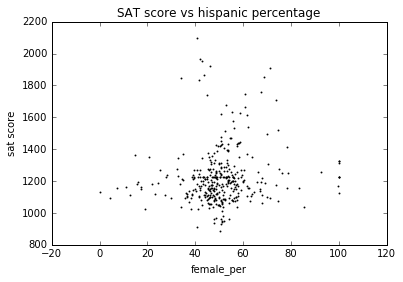

In [18]:
fig, ax = plt.subplots()
ax.scatter(combined["female_per"], combined["sat_score"], s=0.8)
ax.set_xlabel("female_per")
ax.set_ylabel("sat score")
ax.set_title("SAT score vs hispanic percentage")
plt.show()

Most schools have median gender percentage and median sat scores. But a few schools are apart from the main group. There are several schools with pure female students, and their average sat scores are a bit higher than average.

In [19]:
high_fem = combined[combined["female_per"] > 60]
high_fem = high_fem[high_fem["sat_score"] > 1700]
print(high_fem["school_name"])

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object


Does not find anything in common...

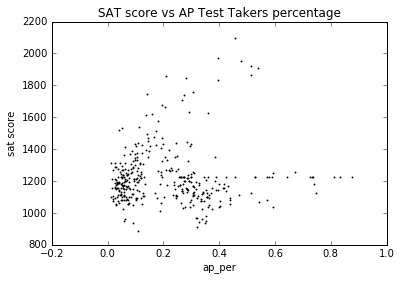

In [20]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"], combined["sat_score"], s=0.8)
ax.set_xlabel("ap_per")
ax.set_ylabel("sat score")
ax.set_title("SAT score vs AP Test Takers percentage")
plt.show()

The schools seems divided into two groups. In the left group sat score increases with ap test taker percentage. The right group has around 30% ap test takers but low sat scores.